In [1]:
import os 

In [2]:
os.getcwd()

'C:\\Users\\Saikrizna'

In [3]:
os.chdir("F:\Analytics Vidhya Al & ML\Customer_Churn")

In [4]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold,train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,roc_curve,precision_score,recall_score
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
warnings.simplefilter(action='ignore',category=UserWarning)

In [5]:
df =pd.read_csv('churn_prediction.csv')

In [6]:
pd.isnull(df).sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

In [7]:
df['gender'].value_counts()

Male      16548
Female    11309
Name: gender, dtype: int64

In [8]:
dict_gender={'Male':1,'Female':0}
df.replace({'gender':dict_gender},inplace=True)
df['gender']=df['gender'].fillna(-1)

In [9]:
df['dependents'].value_counts()

0.0     21435
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
36.0        1
52.0        1
25.0        1
9.0         1
50.0        1
32.0        1
8.0         1
Name: dependents, dtype: int64

In [10]:
df['occupation'].value_counts()

self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [11]:
df['dependents']=df['dependents'].fillna(0)
df['occupation']=df['occupation'].fillna('self_employed')

In [12]:
df['city']=df['city'].fillna(1020)

In [13]:
df['days_since_last_transaction']=df['days_since_last_transaction'].fillna(999)

In [14]:
#coverting occupation to one hot encoded feature 
df=pd.concat([df,pd.get_dummies(df['occupation'],prefix=str('occupation'),prefix_sep='_')],axis=1)

# Scaling Numerical Feature 

In [15]:
num_cols=['customer_nw_category','current_balance','previous_month_end_balance',
          'average_monthly_balance_prevQ','average_monthly_balance_prevQ2','current_month_credit',
'previous_month_credit', 'current_month_debit', 'previous_month_debit','current_month_balance','previous_month_balance']

for i in num_cols:
    df[i]=np.log(df[i]+17000)
std=StandardScaler()
scaled=std.fit_transform(df[num_cols])
scaled=pd.DataFrame(scaled,columns=num_cols)

In [16]:
df_df_org=df.copy()
df=df.drop(columns=num_cols,axis=1)
df=df.merge(scaled,left_index=True,right_index=True,how='left')

In [17]:
y_all=df.churn
df=df.drop(['churn','customer_id','occupation'],axis=1)

# Model Building And Evaluation Metrics

In [18]:
baseline_cols =['current_month_debit', 'previous_month_debit','current_month_balance','previous_month_balance',
               'vintage','occupation_retired','occupation_self_employed','occupation_salaried','occupation_student']
df_baseline_cols= df[baseline_cols]

In [19]:
xtrain,xtest,ytrain,ytest=train_test_split(df_baseline_cols,y_all,test_size=1/3,random_state=11,stratify=y_all)

In [20]:
model=LogisticRegression()
model.fit(xtrain,ytrain)
pred=model.predict_proba(xtest)[:,1]

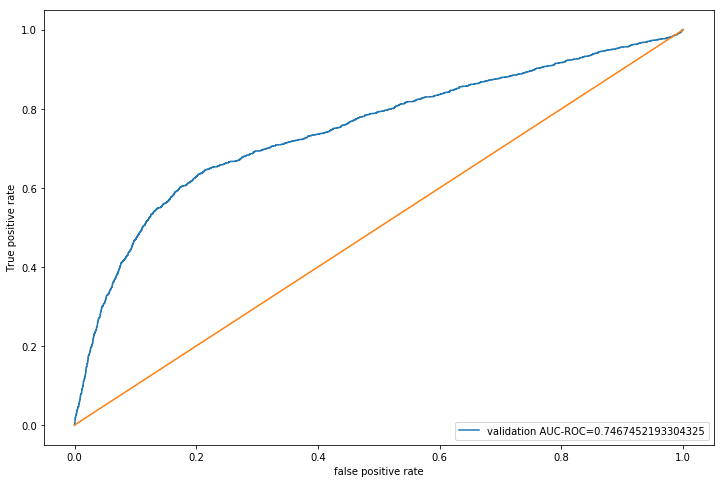

In [21]:
from sklearn.metrics import roc_curve
fpr,tpr,_ =roc_curve(ytest,pred)
auc=roc_auc_score(ytest,pred)
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr,label="validation AUC-ROC="+str(auc))
x=np.linspace(0,1,1000)
plt.plot(x,x,linestyle='-')
plt.xlabel('false positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

In [22]:
pred_val=model.predict(xtest)

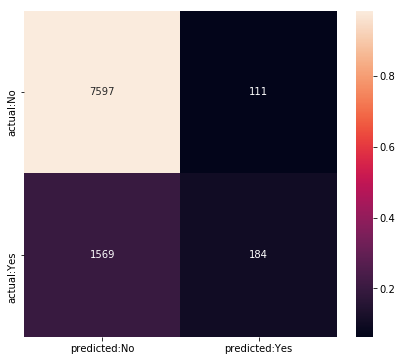

In [23]:
label_preds=pred_val

cm=confusion_matrix(ytest,label_preds)

def plot_confusion_matrix(cm,normalized=True,cmap='black'):
    plt.figure(figsize=[7,6])
    norm_cm=cm
    if normalized:
        norm_cm=cm.astype('float')/cm.sum(axis=1)[:np.newaxis]
        sns.heatmap(norm_cm,annot=cm,fmt='g',xticklabels=['predicted:No','predicted:Yes'],yticklabels=['actual:No','actual:Yes'])
plot_confusion_matrix(cm,['No','Yes'])

In [24]:
recall_score(ytest,pred_val)

0.10496292070735881

# Cross Validation

In [49]:
def cv_score(ml_model,rstate=12,thresold=0.5,cols=df.columns):
    i=1
    cv_scores=[]
    df1=df.copy()
    df1=df[cols]
# 5 fold cross validation stratified on the basis of target  
    kf=StratifiedKFold(n_splits=5,random_state=rstate,shuffle=True)
    for df_index,test_index in kf.split(df1,y_all):
        print('\n{} od KFold {}'.format(i,kf.n_splits))
        xtr,xv1=df1.loc[df_index],df1.loc[test_index]
        ytr,yv1=y_all.loc[df_index],y_all.loc[test_index]
        
# define model for fitting on the training set for each fold 

        model=ml_model
        model.fit(xtr,ytr)
        pred_probs=model.predict_proba(xv1)
        pp=[]
#use thresold to define the classes based on probability values 
        for j in pred_probs[:,1]:
            if j>thresold:
                pp.append(1)
            else:
                pp.append(0)
        
#calculate scores for each fold and print 
        pred_val = pp
        roc_score=roc_auc_score(yv1,pred_probs[:,1])
        recall=recall_score(yv1,pred_val)
        precision=precision_score(yv1,pred_val)
        sufix=""
        msg=""
        msg+="ROC AUC score :{},recall score{:.4f},precision score:{:.4f}".format(roc_score,recall,precision)
        print("{}".format(msg))
        
        cv_scores.append(roc_score)
        i+=1
        return cv_scores



In [50]:
baseline_scores = cv_score(LogisticRegression(),cols=baseline_cols)


1 od KFold 5
ROC AUC score :0.7425841126297401,recall score0.1169,precision score:0.6340
